In [17]:
import pandas as pd
import os
import numpy as np
from scipy import stats

from abag_affinity.utils.config import read_yaml, get_data_paths, get_resources_paths

In [18]:
config = read_yaml("../abag_affinity/config.yaml")

computed_summary_path, _ = get_data_paths(config, "AbDb")
computed_summary_df = pd.read_csv(computed_summary_path)
computed_summary_df = computed_summary_df.set_index("pdb_id")


sabdab_path, _ = get_resources_paths(config, "SAbDab")
sabdab_df = pd.read_csv(sabdab_path, sep="\t")
sabdab_df = sabdab_df.set_index("pdb")
sabdab_df = sabdab_df[~sabdab_df.index.duplicated(keep='first')]

In [19]:
delta_g_columns = ["bound_wildtype vs unbound_wildtype", "bound_wildtype vs unbound_relaxed", "bound_relaxed vs relaxed_unbound", "bound_relaxed vs relaxed_unbound_relaxed"]

In [20]:
def get_best_correlation(df, kd_col, delta_g_col, affinity_columns=delta_g_columns):
    correlations = {}
    for col in affinity_columns:
        # remove outiers 
        # outliers have a zscroe above 3
        mask = np.abs(stats.zscore(df[col])) < 3

        correlations[col] = {
            kd_col: df[col][mask].corr(df[kd_col][mask].astype(float)),
            delta_g_col: df[col][mask].corr(df[delta_g_col][mask].astype(float))
        }
    best_combi = ()
    best_correlation = -1

    for type_ in correlations.keys():
        for measure in correlations[type_].keys():
            if correlations[type_][measure] > best_correlation:
                best_correlation = correlations[type_][measure]
                best_combi = (measure, type_)
                
    return best_combi, best_correlation

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def plot_correlation(df, best_combi):
    mask = np.abs(stats.zscore(df[best_combi[1]])) < 3
    masked_df = df[mask]
    
    masked_df.reset_index(level=0, inplace=True)
    
    plot = sns.jointplot(x=masked_df[best_combi[0]], y=masked_df[best_combi[1]], kind="reg")
    
    r, p = stats.pearsonr(x=masked_df[best_combi[0]], y=masked_df[best_combi[1]])
    
    phantom, = plot.ax_joint.plot([], [], linestyle="", alpha=0)
    plot.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])

## Rosetta Energy Function Results

### Comparison of computed affinity values with benchmark values

In [22]:
benchmark_path, _ = get_resources_paths(config, "AntibodyBenchmark")
benchmark_df = pd.read_excel(benchmark_path)
benchmark_df["pdb_id"] = benchmark_df["Complex PDB"].apply(lambda x: x.split("_")[0].lower())
benchmark_df = benchmark_df.set_index("pdb_id")
benchmark_df = benchmark_df.replace(" ", None)

# fill unavailable affinity values from SAbDab
benchmark_df = benchmark_df.join(sabdab_df, how="left")
#benchmark_df['Kd (nM)'] = benchmark_df['Kd (nM)'].fillna(benchmark_df['affinity'])
#benchmark_df['ΔG (kcal/mol)'] = benchmark_df['ΔG (kcal/mol)'].fillna(benchmark_df['delta_g'])
benchmark_df["delta_g"] = benchmark_df["delta_g"].fillna(benchmark_df['ΔG (kcal/mol)'])

benchmark_df = benchmark_df[benchmark_df["ΔG (kcal/mol)"].notnull() & benchmark_df["Kd (nM)"].notnull()]
benchmark_df["ΔG (kcal/mol)"] = benchmark_df["ΔG (kcal/mol)"].astype(float)
benchmark_df["Kd (nM)"] = benchmark_df["Kd (nM)"].astype(float)

In [23]:
benchmark_overlap_df = computed_summary_df.join(benchmark_df, how="inner")
print("Total number of cases that overlap >>>", len(benchmark_overlap_df))

Total number of cases that overlap >>> 35


In [24]:
best_combi, best_correlation = get_best_correlation(benchmark_overlap_df,"affinity","delta_g")
print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

Best pearson correlation between delta_g and bound_wildtype vs unbound_relaxed of 0.3111328700586756


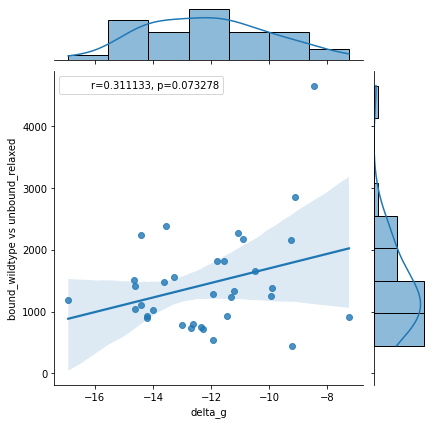

In [25]:
plot_correlation(benchmark_overlap_df, best_combi)

### Comparison of computed affinity values with SAbDab values

In [26]:
sabdab_overlap_df = computed_summary_df.join(sabdab_df, how="inner")
sabdab_overlap_df = sabdab_overlap_df[sabdab_overlap_df["delta_g"].notnull() & sabdab_overlap_df["affinity"].notnull()]
print("Total number of cases that overlap >>>", len(sabdab_overlap_df))

Total number of cases that overlap >>> 394


In [27]:
best_combi, best_correlation = get_best_correlation(sabdab_overlap_df,"affinity","delta_g")
print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

Best pearson correlation between delta_g and bound_relaxed vs relaxed_unbound of 0.20836852479551882


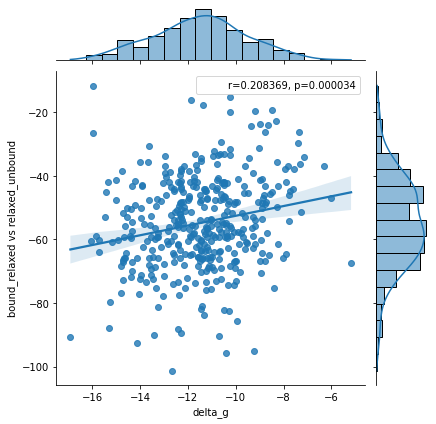

In [28]:
plot_correlation(sabdab_overlap_df, best_combi)

### Results using Benchmark Script and Rosetta Suite 2017.219

In [93]:
from collections import defaultdict
# get pdb_ids
with open("../../other_repos/antibody_benchmark/list.txt") as f:
    pdbs = f.readlines()

# get delta g scores
with open("../../other_repos/antibody_benchmark/scores.txt") as f:
    scores = f.readlines()

results = defaultdict(dict)
pdb_idx = 0
for score in scores:
    if score == 'Antibody\n':
        score_type = "Antibody"
    if score == 'Antigen\n':
        score_type = "Antigen"
    if score == 'Complex\n':
        score_type = "Complex"
    if score in ["\n", 'Antibody\n', 'Antigen\n', 'Complex\n', 'score\n']:
        pdb_idx = 0
        continue

    results[pdbs[pdb_idx].strip().lower()][score_type] = score.strip()
    pdb_idx += 1
    
rosetta_scores = pd.DataFrame(results.values())
rosetta_scores.index = results.keys()
rosetta_scores = rosetta_scores.astype(float)
rosetta_scores["rosetta_delta_g"] = rosetta_scores["Complex"] - rosetta_scores["Antibody"] - rosetta_scores["Antigen"]

In [94]:
scores_overlap_df = rosetta_scores.join(benchmark_df, how="inner", lsuffix="benchmark")
scores_overlap_df = scores_overlap_df[scores_overlap_df["delta_g"].notnull()]
print("Total number of cases that overlap >>>", len(scores_overlap_df))

Total number of cases that overlap >>> 53


In [95]:
best_combi, best_correlation = get_best_correlation(scores_overlap_df,"affinity","delta_g", affinity_columns=["rosetta_delta_g"])
print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

Best pearson correlation between delta_g and rosetta_delta_g of 0.23512244487227552


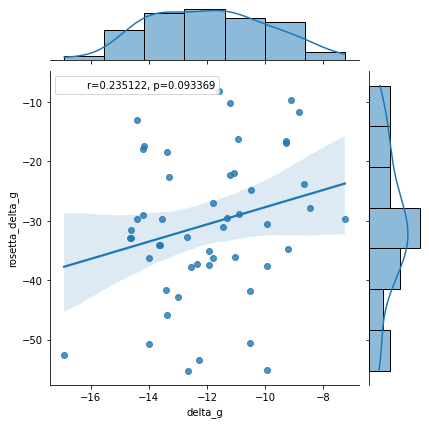

In [96]:
plot_correlation(scores_overlap_df, best_combi)

## FoldX Results

### Comparison of computed affinity values with Benchmark values

In [29]:
foldx_summary_df = pd.read_csv("../data/AbDb/foldx_results.csv")
foldx_summary_df = foldx_summary_df.set_index("pdb_id")

benchmark_foldx_overlap_df = foldx_summary_df.join(benchmark_df, how="inner", lsuffix="_abdb")
print("Total number of cases that overlap >>>", len(benchmark_foldx_overlap_df))

Total number of cases that overlap >>> 35


In [30]:
best_combi, best_correlation = get_best_correlation(benchmark_foldx_overlap_df,"affinity","delta_g", ["Interaction Energy", "Interface Residues"])
print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

Best pearson correlation between affinity and Interface Residues of -0.00842803981111274


### Comparison of computed affinity values with SAbDab values

In [31]:
sabdab_foldx_overlap_df = foldx_summary_df.join(sabdab_df, how="inner")
sabdab_foldx_overlap_df = sabdab_foldx_overlap_df[sabdab_foldx_overlap_df["delta_g"].notnull() & sabdab_foldx_overlap_df["affinity"].notnull()]
print("Total number of cases that overlap >>>", len(sabdab_foldx_overlap_df))

Total number of cases that overlap >>> 396


In [32]:
best_combi, best_correlation = get_best_correlation(sabdab_foldx_overlap_df,"affinity","delta_g", ["Interaction Energy", "Interface Residues"])
print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

Best pearson correlation between delta_g and Interaction Energy of 0.11870833055543957


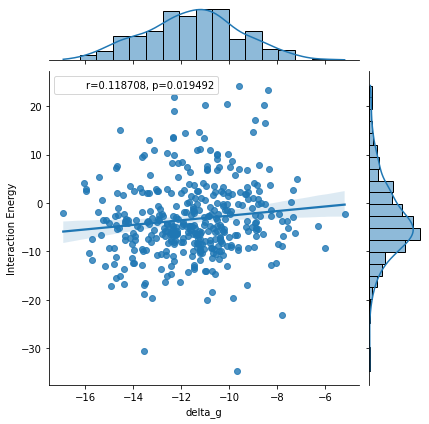

In [33]:
plot_correlation(sabdab_foldx_overlap_df, best_combi)

## Comparison of using given unbound / bound complexes with Rosetta

In [34]:
benchmark_scores_path, _ = get_data_paths(config, "AntibodyBenchmark")
benchmark_scores_df = pd.read_csv(benchmark_scores_path)
benchmark_scores_df = benchmark_scores_df.set_index("pdb_id")

In [35]:
#benchmark_scores_df = benchmark_scores_df.reindex(benchmark_overlap_df.index).dropna()
#len(benchmark_scores_df)

In [36]:
benchmark_scores_overlap_df = benchmark_scores_df.join(benchmark_df, how="inner")
benchmark_scores_overlap_df = benchmark_scores_overlap_df[["binding_energy", "ΔG (kcal/mol)", "Kd (nM)"]]
print("Total number of cases that overlap >>>", len(benchmark_scores_overlap_df))

Total number of cases that overlap >>> 52


In [37]:
best_combi, best_correlation = get_best_correlation(benchmark_scores_overlap_df, "ΔG (kcal/mol)","Kd (nM)", ["binding_energy"])
print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

Best pearson correlation between ΔG (kcal/mol) and binding_energy of 0.13298576409792645


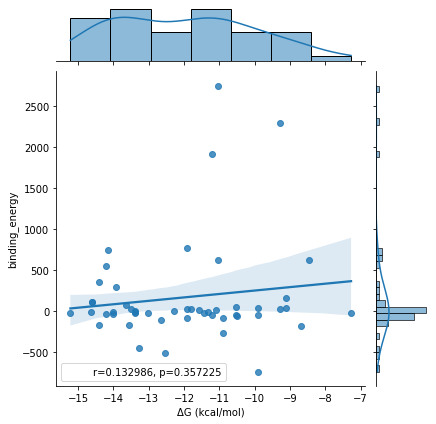

In [38]:
plot_correlation(benchmark_scores_overlap_df, best_combi)

## CSM-AB Results

### Comparison of CSM-AB with Benchmark values

In [39]:
csmab_scores_df = pd.read_csv("../../other_repos/CSM-AB/results.csv")
csmab_scores_df["pdb_id"] = csmab_scores_df["pdb_id"].apply(lambda x: x.lower())
csmab_scores_df = csmab_scores_df.set_index("pdb_id")

In [40]:
csmab_overlap_df = csmab_scores_df.join(benchmark_df, how="inner")
csmab_overlap_df = csmab_overlap_df[["prediction", "ΔG (kcal/mol)", "Kd (nM)"]]

In [41]:
best_combi, best_correlation = get_best_correlation(csmab_overlap_df, "ΔG (kcal/mol)","Kd (nM)", ["prediction"])
print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

Best pearson correlation between ΔG (kcal/mol) and prediction of 0.08039933541581651


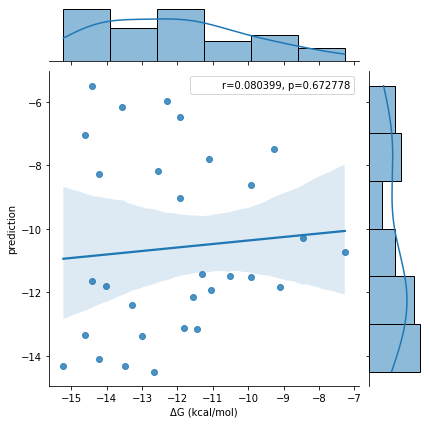

In [42]:
plot_correlation(csmab_overlap_df, best_combi)

### Comparison of CSM-AB with SAbDab values

In [43]:
csmab_sabdab_overlap_df = csmab_scores_df.join(sabdab_df, how="inner")
csmab_sabdab_overlap_df = csmab_sabdab_overlap_df[["prediction", "affinity", "delta_g"]]

In [44]:
best_combi, best_correlation = get_best_correlation(csmab_sabdab_overlap_df, "delta_g","affinity", ["prediction"])
print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

Best pearson correlation between delta_g and prediction of 0.3252794618073002


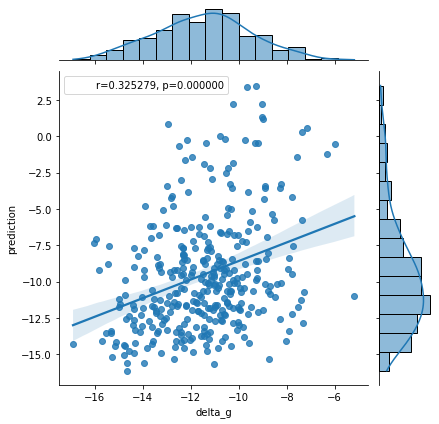

In [45]:
plot_correlation(csmab_sabdab_overlap_df, best_combi)

In [46]:
# removing training data
training_data = pd.read_csv("../../other_repos/CSM-AB/1_training.csv")["pdb"].values

csmab_sabdab_overlap_df = csmab_sabdab_overlap_df[~csmab_sabdab_overlap_df.index.isin(training_data)]

In [47]:
best_combi, best_correlation = get_best_correlation(csmab_sabdab_overlap_df, "delta_g","affinity", ["prediction"])
print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

Best pearson correlation between delta_g and prediction of 0.1635754567016572


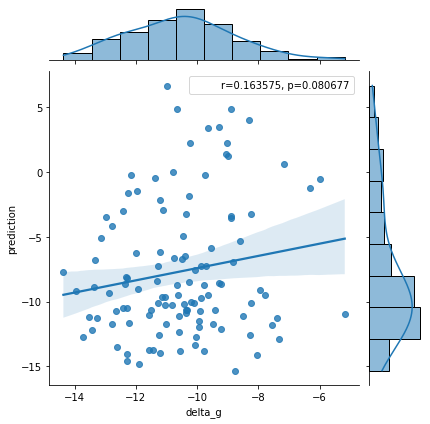

In [48]:
plot_correlation(csmab_sabdab_overlap_df, best_combi)

## Dataset comparison

### Comparison of SAbDab Values with benchmark values

In [49]:
overlap_sabdab_df = sabdab_df.join(benchmark_df, how="inner", rsuffix="benchmark_")
overlap_sabdab_df = overlap_sabdab_df[["delta_g", "affinity", "ΔG (kcal/mol)","Kd (nM)"]].dropna()

In [50]:
best_combi, best_correlation = get_best_correlation(overlap_sabdab_df, "ΔG (kcal/mol)","Kd (nM)", ["delta_g", "affinity"])
print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

Best pearson correlation between Kd (nM) and affinity of 0.998591935333842


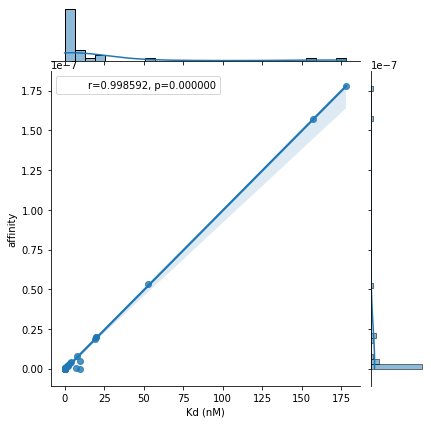

In [51]:
plot_correlation(overlap_sabdab_df, best_combi)

In [52]:
best_combi, best_correlation = get_best_correlation(overlap_sabdab_df, "ΔG (kcal/mol)","Kd (nM)", ["delta_g"])
print("Best pearson correlation between {} and {} of {}".format(best_combi[0], best_combi[1], best_correlation))

Best pearson correlation between ΔG (kcal/mol) and delta_g of 0.9250048061007269


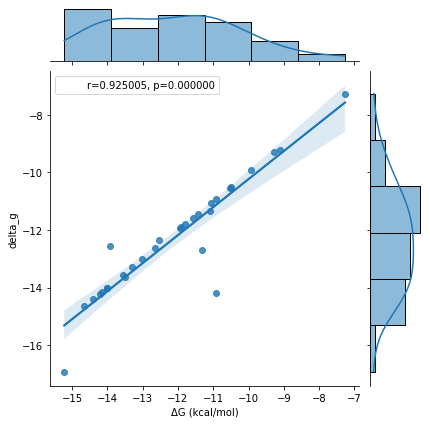

In [53]:
plot_correlation(overlap_sabdab_df, best_combi)